In [2]:
pip install scikit-fuzzy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: C:\Users\marce\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install paho-mqtt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: C:\Users\marce\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\marce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


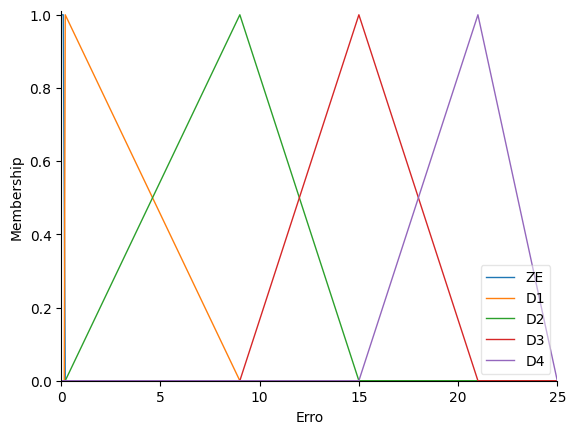

In [4]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import tkinter as tk

# Definição de Variáveis
Erro = ctrl.Antecedent(np.arange(0, 25.01, 0.01), 'Erro') #erro maximo 25

# Funções de Pertinência:
Erro['ZE'] = fuzz.trapmf(Erro.universe, [0, 0, 0.1, 0.2])
Erro['D1'] = fuzz.trimf(Erro.universe, [0.15, 0.2, 9])
Erro['D2'] = fuzz.trimf(Erro.universe, [0.2, 9, 15])
Erro['D3'] = fuzz.trimf(Erro.universe, [9, 15, 21])
Erro['D4'] = fuzz.trimf(Erro.universe, [15, 21, 25])

# You can see how these look with .view()
Erro.view()

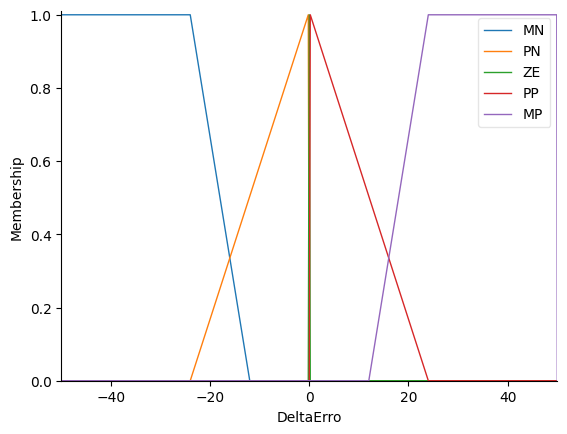

In [5]:
deltaErro = ctrl.Antecedent(np.arange(-50, 50.1, 0.1), label='DeltaErro')

deltaErro['MN'] = fuzz.trapmf(deltaErro.universe, [-50, -50, -24, -12])
deltaErro['PN'] = fuzz.trimf(deltaErro.universe, [-24, -0.2, 0])
deltaErro['ZE'] = fuzz.trimf(deltaErro.universe, [-0.2, 0, 0.2])
deltaErro['PP'] = fuzz.trimf(deltaErro.universe, [0, 0.2, 24])
deltaErro['MP'] = fuzz.trapmf(deltaErro.universe,[12, 24, 50, 50])
# You can see how these look with .view()
deltaErro.view()

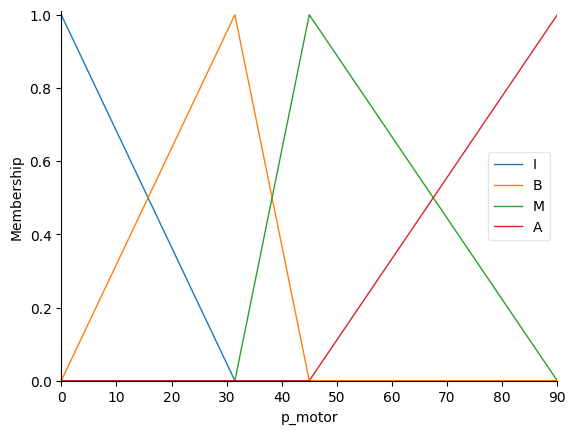

In [6]:
p_motor = ctrl.Consequent(np.arange(0, 90.5, 0.5), label='p_motor')

p_motor['I'] = fuzz.trimf(p_motor.universe, [0, 0, 31.5]) #INICIAL
p_motor['B'] = fuzz.trimf(p_motor.universe, [0, 31.5, 45]) #BAIXO
p_motor['M'] = fuzz.trimf(p_motor.universe, [31.5, 45.0, 90]) #MEDIO
p_motor['A'] = fuzz.trimf(p_motor.universe, [45.0, 90.0, 90]) #ALTO

p_motor.view()

In [7]:
#Inferência

regra1 = ctrl.Rule(Erro['ZE'] & deltaErro['MN'], p_motor['I'])
regra2 = ctrl.Rule(Erro['ZE'] & deltaErro['PN'], p_motor['I'])
regra3 = ctrl.Rule(Erro['ZE'] & deltaErro['ZE'], p_motor['I'])
regra4 = ctrl.Rule(Erro['ZE'] & deltaErro['PP'], p_motor['I'])
regra5 = ctrl.Rule(Erro['ZE'] & deltaErro['MP'], p_motor['I'])

regra6 = ctrl.Rule(Erro['D1'] & deltaErro['MN'], p_motor['B'])
regra7 = ctrl.Rule(Erro['D1'] & deltaErro['PN'], p_motor['B'])
regra8 = ctrl.Rule(Erro['D1'] & deltaErro['ZE'], p_motor['I'])
regra9 = ctrl.Rule(Erro['D1'] & deltaErro['PP'], p_motor['B'])
regra10 = ctrl.Rule(Erro['D1'] & deltaErro['MP'], p_motor['B'])

regra11 = ctrl.Rule(Erro['D2'] & deltaErro['MN'], p_motor['M'])
regra12 = ctrl.Rule(Erro['D2'] & deltaErro['PN'], p_motor['B'])
regra13 = ctrl.Rule(Erro['D2'] & deltaErro['ZE'], p_motor['I'])
regra14 = ctrl.Rule(Erro['D2'] & deltaErro['PP'], p_motor['B'])
regra15 = ctrl.Rule(Erro['D2'] & deltaErro['MP'], p_motor['M'])

regra16 = ctrl.Rule(Erro['D3'] & deltaErro['MN'], p_motor['M'])
regra17 = ctrl.Rule(Erro['D3'] & deltaErro['PN'], p_motor['M'])
regra18 = ctrl.Rule(Erro['D3'] & deltaErro['ZE'], p_motor['I'])
regra19 = ctrl.Rule(Erro['D3'] & deltaErro['PP'], p_motor['M'])
regra20 = ctrl.Rule(Erro['D3'] & deltaErro['MP'], p_motor['M'])

regra21 = ctrl.Rule(Erro['D4'] & deltaErro['MN'], p_motor['A'])
regra22 = ctrl.Rule(Erro['D4'] & deltaErro['PN'], p_motor['M'])
regra23 = ctrl.Rule(Erro['D4'] & deltaErro['ZE'], p_motor['I'])
regra24 = ctrl.Rule(Erro['D4'] & deltaErro['PP'], p_motor['M'])
regra25 = ctrl.Rule(Erro['D4'] & deltaErro['MP'], p_motor['A'])

# determinam como as variáveis de entrada (Erro e DeltaErro) se combinam para influenciar a variável de saída (p_motor).
# As regras fuzzy definem como as entradas fuzzy devem ser combinadas para determinar as ações de controle.

In [8]:
# Sistema de controle
sistema_controle = ctrl.ControlSystem([
    regra1, regra2, regra3, regra4, regra5,
    regra6, regra7, regra8, regra9, regra10,
    regra11, regra12, regra13, regra14, regra15,
    regra16, regra17, regra18, regra19, regra20,
    regra21, regra22, regra23, regra24, regra25
])

# Associa o sistema de controle à simulação
simulacao = ctrl.ControlSystemSimulation(sistema_controle)

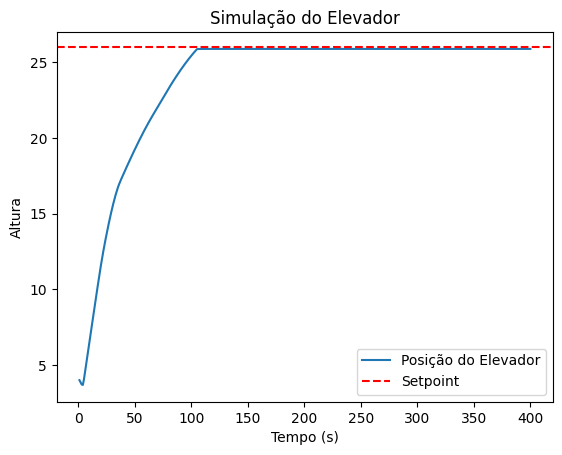

In [10]:
# Função de simulação do elevador
def simular_elevador(andarAtual, andarDeslocado):
    posicao, posicaoAtual = [andarAtual], andarAtual
    erroAltura = andarDeslocado - posicaoAtual

    # Simulação inicial: aceleração do motor nos primeiros 3 segundos
    for t in np.arange(0.1, 3.1, 0.1):
        potenciaMotor = t * 0.315 / 3  # o motor acelera linearmente até 31,5%
        posicaoAtual = posicaoAtual * 0.996 * (1 if erroAltura > 0 else -1) + potenciaMotor * 0.00951
        if t == round(t, 0):
            posicao = np.append(posicao, posicaoAtual)

    erro_anterior = andarDeslocado - posicaoAtual

    # Simulação principal: controle fuzzy para ajustar a posição do elevador
    for _ in np.arange(3, 400, 1):
        erroAltura = andarDeslocado - posicaoAtual
        erro_atual = abs(erroAltura)
        simulacao.input['Erro'] = erro_atual
        deltaErro_atual = erro_anterior - erro_atual
        simulacao.input['DeltaErro'] = deltaErro_atual
        simulacao.compute()
        potenciaMotor = simulacao.output['p_motor']
        posicaoAtual = abs(posicaoAtual * 0.996 * (1 if erroAltura > 0 else -1) + potenciaMotor * 0.00951)
        posicao = np.append(posicao, posicaoAtual)
        erro_anterior = erro_atual
        if abs(posicaoAtual - andarDeslocado) < 0.1:
            break

    return posicao

# Função para plotar o gráfico
def plotar_grafico(posicao, setpoint):
    plt.plot(np.arange(1, len(posicao) + 1), posicao, label='Posição do Elevador')
    plt.axhline(y=setpoint, color='r', linestyle='--', label='Setpoint')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Altura')
    plt.legend()
    plt.title('Simulação do Elevador')
    plt.show()

# Função para chamar o elevador
def chamar_elevador(andar):
    global andarAtual
    altura_andares = [4, 8, 11, 14, 17, 20, 23, 26, 29]  # Alturas dos andares
    andarDeslocado = altura_andares[andar]  # Obter a altura correspondente ao andar
    if andarAtual == andarDeslocado:  # Verifica se o andar atual é o mesmo que o andar chamado
        print("O elevador já está no andar solicitado.")
        return
    posicao = simular_elevador(andarAtual, andarDeslocado)
    andarAtual = andarDeslocado  # Atualiza a posição atual do elevador
    plotar_grafico(posicao, andarDeslocado)  # Plota o gráfico da simulação

# Criação da interface gráfica
root = tk.Tk()
root.title("Controle do Elevador")

andarAtual = 4  # Térreo tem altura 4

# Adicionando botões para cada andar
andares = ['T', 1, 2, 3, 4, 5, 6, 7, 8]
for i, andar in enumerate(andares):
    button = tk.Button(root, text=f"Andar {andar}", command=lambda i=i: chamar_elevador(i))
    button.pack(pady=5)

# Iniciando a interface gráfica
root.mainloop()